In [1]:
# libs

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from kerastuner.tuners import RandomSearch

/tmp/ipykernel_23/2930936595.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## 1. Load the data

In [2]:
data_path = '/kaggle/input/gooogle-stock-price/'
train_df = pd.read_csv(data_path + 'Google_Stock_Price_Train.csv')
test_df = pd.read_csv(data_path + 'Google_Stock_Price_Test.csv')

In [3]:
train_df

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


We need to check the basic information.

In [4]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


(None, None)

We find that `Close` and `Volume` column are object type in `train_data`, we need to carefully check them.

In [5]:
mask = pd.to_numeric(train_df['Close'], errors='coerce').isna()
problematic_rows = train_df[mask]
print("Error rows：")
print(problematic_rows)

Error rows：
           Date    Open    High     Low     Close      Volume
451  10/18/2013  486.47  505.83  485.18  1,008.64  23,219,400
452  10/21/2013  503.84  507.60  497.91  1,000.55   7,283,700
453  10/22/2013  500.62  504.61  496.04  1,004.24   4,433,700
454  10/23/2013  498.63  515.44  498.45  1,028.59   5,346,300
455  10/24/2013  514.01  518.34  510.49  1,022.74   4,199,700
..          ...     ...     ...     ...       ...         ...
555   3/20/2014  597.73  602.55  595.45  1,193.88   3,381,900
556   3/21/2014  600.90  602.56  589.02  1,179.80   6,441,000
557   3/24/2014  589.88  590.24  570.84  1,154.76   6,096,800
558   3/25/2014  580.82  582.74  571.36  1,155.55   4,838,400
559   3/26/2014  578.84  583.60  563.64  1,128.87   5,179,200

[109 rows x 6 columns]


Now we can see, it is because `1,008.64`, not 1008.64

In [6]:
train_df['Close'] = train_df['Close'].str.replace(',', '').astype(float)
train_df['Volume'] = train_df['Volume'].str.replace(',', '').astype(float)

test_df['Volume'] = test_df['Volume'].str.replace(',', '').astype(float)

In [7]:
train_df.tail()

,Date,Open,High,Low,Close,Volume
1253,12/23/2016,790.90,792.74,787.28,789.91,623400.0
1254,12/27/2016,790.68,797.86,787.66,791.55,789100.0
1255,12/28/2016,793.70,794.23,783.20,785.05,1153800.0
1256,12/29/2016,783.33,785.93,778.92,782.79,744300.0
1257,12/30/2016,782.75,782.78,770.41,771.82,1770000.0


In [8]:
test_df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,1657300.0
1,1/4/2017,788.36,791.34,783.16,786.90,1073000.0
2,1/5/2017,786.08,794.48,785.02,794.02,1335200.0
3,1/6/2017,795.26,807.90,792.20,806.15,1640200.0
4,1/9/2017,806.40,809.97,802.83,806.65,1272400.0


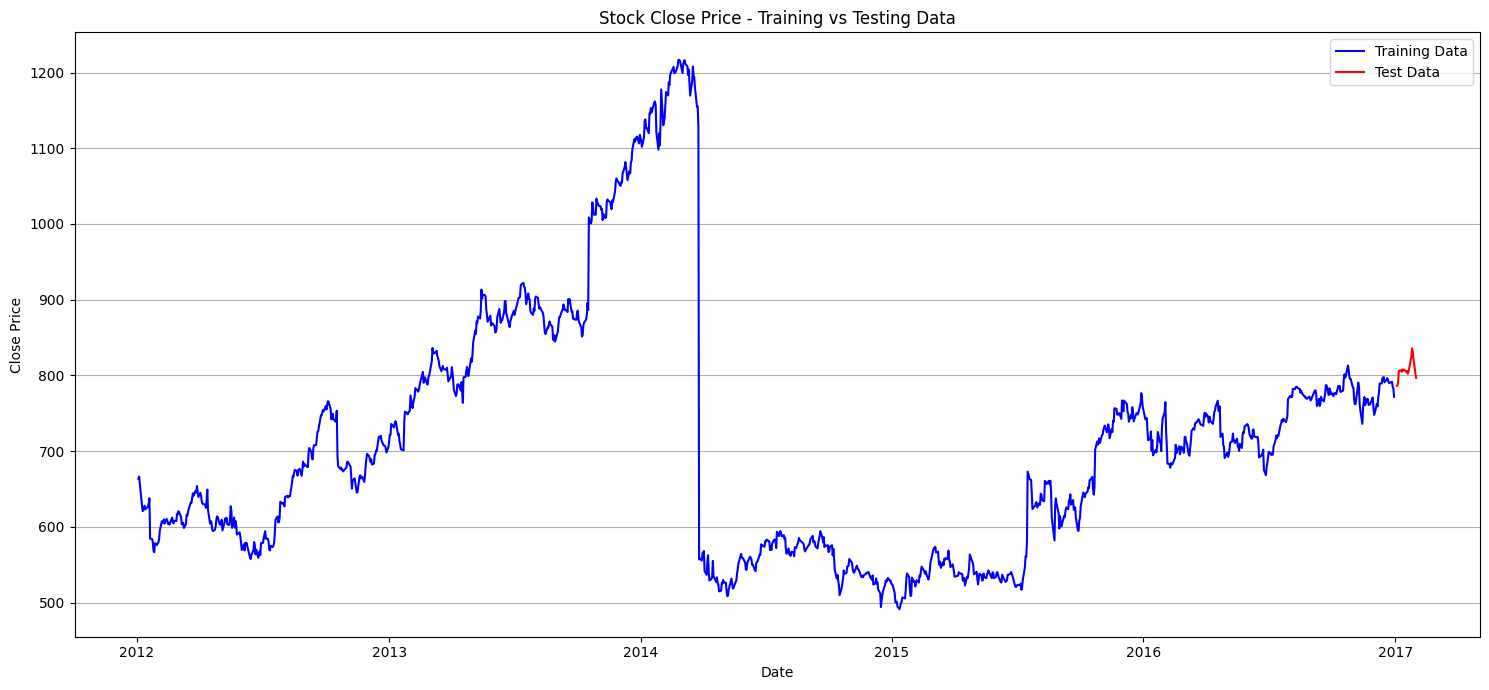

In [9]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

plt.figure(figsize=(15, 7))
plt.plot(train_df['Date'], train_df['Close'], label='Training Data', color='blue')
plt.plot(test_df['Date'], test_df['Close'], label='Test Data', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Close Price - Training vs Testing Data')
plt.legend()
plt.grid(axis='y')

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## 2. Split the data

In [10]:
all_data = pd.concat([train_df, test_df], axis=0)


In [11]:
all_data.tail(30)

,Date,Open,High,Low,Close,Volume
1248,2016-12-16,800.40,800.86,790.29,790.80,2443800.0
1249,2016-12-19,790.22,797.66,786.27,794.20,1232100.0
1250,2016-12-20,796.76,798.65,793.27,796.42,951000.0
1251,2016-12-21,795.84,796.68,787.10,794.56,1211300.0
1252,2016-12-22,792.36,793.32,788.58,791.26,972200.0
1253,2016-12-23,790.90,792.74,787.28,789.91,623400.0
1254,2016-12-27,790.68,797.86,787.66,791.55,789100.0
1255,2016-12-28,793.70,794.23,783.20,785.05,1153800.0
1256,2016-12-29,783.33,785.93,778.92,782.79,744300.0
1257,2016-12-30,782.75,782.78,770.41,771.82,1770000.0


we need to scale the data, but we can just train scaler in trian data, not all data.

In [12]:
train_features = train_df[['Open', 'High', 'Low', 'Close', 'Volume']].values
scaler = MinMaxScaler()
scaler.fit(train_features)

MinMaxScaler()

In [13]:
def prepare_data(data, scaler, lookback=30):
    scaled_data = scaler.transform(data)
    
    X, y = [], []
    for i in range(len(scaled_data) - lookback):
        X.append(scaled_data[i:(i + lookback)])
        y.append(scaled_data[i + lookback])
    
    return np.array(X), np.array(y)


In [14]:
all_features = all_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
X, y = prepare_data(all_features, scaler, lookback=30)

test_length = len(test_df)
X_test = X[-test_length:]
y_test = y[-test_length:]

# we use remaining data to train and val
remaining_X = X[:-test_length]
remaining_y = y[:-test_length]
train_size = int(len(remaining_X) * 0.8)

X_train = remaining_X[:train_size]
y_train = remaining_y[:train_size]

X_val = remaining_X[train_size:]
y_val = remaining_y[train_size:]

print("Shape of data:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

Shape of data:
X_train: (982, 30, 5)
X_val: (246, 30, 5)
X_test: (20, 30, 5)


Show the close price of all data

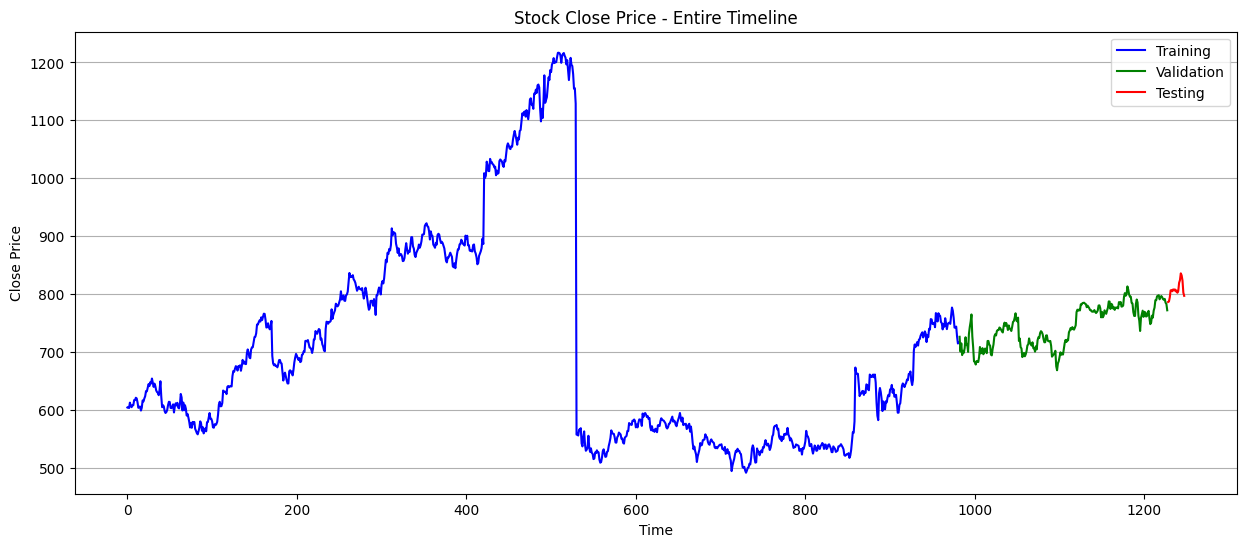

In [15]:

all_actual = scaler.inverse_transform(y)[:, 3]  # 3 is Close's index 3 is Close's index

# calculate the index of each part
train_size = len(X_train)
val_size = len(X_val)

# split data
train_data = all_actual[:train_size]
val_data = all_actual[train_size:train_size+val_size]
test_data = all_actual[train_size+val_size:]


plt.figure(figsize=(15, 6))
plt.plot(range(len(train_data)), train_data, label='Training', color='blue')
plt.plot(range(len(train_data), len(train_data)+len(val_data)), val_data, label='Validation', color='green')
plt.plot(range(len(train_data)+len(val_data), len(all_actual)), test_data, label='Testing', color='red')

plt.title('Stock Close Price - Entire Timeline')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.grid(axis='y')
plt.legend()
plt.show()

check our data

In [16]:
def inspect_data(X, y, scaler, sample_index=0, days_to_show=5, name="Dataset"):
    """
    The function to check the time series data
    
    Parameters: 
    X: input data (sample number, time steps, feature number)
    y: target data (sample number, feature number)
    scaler: scaler for inverse normalization
    sample_index: sample index to inspect
    days_to_show: days to show
    name: dataset name (e.g. "Training", "Test")
    """
    print(f"\n=== Inspecting {name} Data ===")
    print(f"Total samples: {len(X)}")
    print(f"\nSample {sample_index} shape:")
    print(f"X shape: {X[sample_index].shape}")
    print(f"y shape: {y[sample_index].shape}")
    
    print(f"\nFirst {days_to_show} days of input sequence (normalized):")
    print(X[sample_index][:days_to_show])
    
    print("\nTarget (normalized):")
    print(y[sample_index])
    
    # inverse normalization
    original_X = scaler.inverse_transform(X[sample_index][0].reshape(1, -1))
    original_y = scaler.inverse_transform(y[sample_index].reshape(1, -1))
    
    print("\nFirst day data in original scale:")
    print("Features (Open, High, Low, Close, Volume):", original_X[0])
    print("Target in original scale:", original_y[0])

# check training data
inspect_data(X_train, y_train, scaler, sample_index=0, name="Training")

# check test data
inspect_data(X_test, y_test, scaler, sample_index=0, name="Test")


=== Inspecting Training Data ===
Total samples: 982

Sample 0 shape:
X shape: (30, 5)
y shape: (5,)

First 5 days of input sequence (normalized):
[[0.08581368 0.09640129 0.09044931 0.23757287 0.29525831]
 [0.09701243 0.09834351 0.09823458 0.24151427 0.22993592]
 [0.09433366 0.09251685 0.09408623 0.22878051 0.26361233]
 [0.09156187 0.08881917 0.08800576 0.21641884 0.21617942]
 [0.07984225 0.07671765 0.06106986 0.1785483  0.46779736]]

Target (normalized):
[0.04873875 0.04502587 0.04343461 0.15531331 0.19471366]

First day data in original scale:
Features (Open, High, Low, Close, Volume): [3.2525e+02 3.3283e+02 3.2497e+02 6.6359e+02 7.3805e+06]
Target in original scale: [3.0532e+02 3.0532e+02 3.0015e+02 6.0390e+02 4.8699e+06]

=== Inspecting Test Data ===
Total samples: 20

Sample 0 shape:
X shape: (30, 5)
y shape: (5,)

First 5 days of input sequence (normalized):
[[0.90743359 0.91786655 0.9225072  0.38591293 0.05190629]
 [0.91571173 0.92216184 0.91449462 0.3711809  0.06164197]
 [0.899

## 3. LSTM model

### 3.1 Basic model

In [17]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dropout(0.2),
        Dense(units=32),
        Dense(units=5)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae', 'mape'])
    
    return model

# create model
input_shape = (30, 5)  # (time steps, feature number) 
model_base = build_lstm_model(input_shape)

model_base.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,653 (514.27 KB)

 Trainable params: 131,653 (514.27 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',      # monitor validation loss
    patience=20,             # if no improvement in 20 epochs, stop
    mode='min',             
    restore_best_weights=True  # restore best weights
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',        
    monitor='val_loss',
    save_best_only=True,    
    mode='min',
    verbose=1
)



# train model
history_base = model_base.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0567 - mae: 0.1711 - mape: 72299.5156
Epoch 1: val_loss improved from inf to 0.00956, saving model to best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0550 - mae: 0.1678 - mape: 72547.7891 - val_loss: 0.0096 - val_mae: 0.0795 - val_mape: 16.9353
Epoch 2/100
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107 - mae: 0.0712 - mape: 31632.1250
Epoch 2: val_loss improved from 0.00956 to 0.00299, saving model to best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0104 - mae: 0.0701 - mape: 31598.6719 - val_loss: 0.0030 - val_mae: 0.0443 - val_mape: 12.0416
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0603 - mape: 36773.7617
Epoch 3: val_loss improved from 0.00299 to 0.00185, saving model to best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077 - mae: 0.0602 - mape: 37533.2969 - val_loss: 0.0018 - val_mae: 0.0311 - val_mape: 9.9537
Epoch 4/100
26/31 

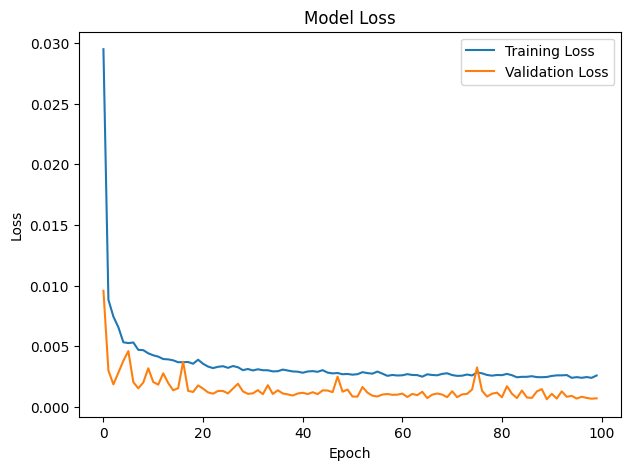

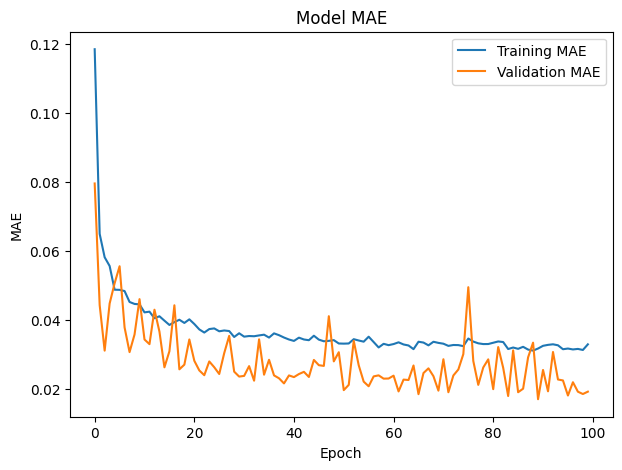

In [19]:
def plot_training_history_separately(history):
    # Plot loss curve
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot MAE curve
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

plot_training_history_separately(history_base)

In [40]:
test_loss_base, test_mae_base, test_mape_base = model_base.evaluate(X_test, y_test, verbose=0)

print("\nTest Set Performance (Normalized Scale):")
print(f"Loss (MSE): {test_loss_base:.6f}")
print(f"MAE: {test_mae_base:.6f}")
print(f"MAPE: {test_mape_base:.6f}")


Test Set Performance (Normalized Scale):
Loss (MSE): 0.000723
MAE: 0.022220
MAPE: 8.014678


### 3.2 Tune the hyper-params

In [41]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   return_sequences=True, input_shape=(30, 5)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(5))
    
    # add learning rate as hyper-parameter
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    # add optimizer as hyper-parameter
    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop'])
    
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'adamw':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mape'])
    return model

In [42]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir',
    project_name='stock_price_prediction'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          # if no improvement in 5 rounds, stop
    restore_best_weights=True
)


tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # add early stopping callback
)

Trial 50 Complete [00h 00m 07s]
val_loss: 0.0012640358181670308

Best val_loss So Far: 0.0006500469171442091
Total elapsed time: 00h 20m 01s


In [61]:
tuner.results_summary(num_trials=5)

Results summary
Results in my_dir/stock_price_prediction
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 20 summary
Hyperparameters:
units: 128
dropout: 0.4
learning_rate: 0.008818051753728646
optimizer: adam
Score: 0.0006500469171442091

Trial 37 summary
Hyperparameters:
units: 128
dropout: 0.5
learning_rate: 0.004055105022756616
optimizer: adamw
Score: 0.0007703301962465048

Trial 30 summary
Hyperparameters:
units: 128
dropout: 0.4
learning_rate: 0.0019933868284204735
optimizer: adam
Score: 0.0008630770025774837

Trial 09 summary
Hyperparameters:
units: 96
dropout: 0.1
learning_rate: 0.0014194016660592278
optimizer: adamw
Score: 0.0009035360999405384

Trial 06 summary
Hyperparameters:
units: 96
dropout: 0.4
learning_rate: 0.0011057457303537271
optimizer: adamw
Score: 0.00090699054999277


In [49]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

Best Hyperparameters: {'units': 128, 'dropout': 0.4, 'learning_rate': 0.008818051753728646, 'optimizer': 'adam'}


In [50]:
best_model_tuned = tuner.get_best_models(num_models=1)[0]

In [52]:
test_loss_tuned, test_mae_tuned, test_mape_tuned = best_model_tuned.evaluate(X_test, y_test, verbose=0)

print("\nTest Set Performance (Normalized Scale):")
print(f"Loss (MSE): {test_loss_tuned:.6f}")
print(f"MAE: {test_mae_tuned:.6f}")
print(f"MAPE: {test_mape_tuned:.6f}")


Test Set Performance (Normalized Scale):
Loss (MSE): 0.000686
MAE: 0.022169
MAPE: 8.912862


## 4. Evaluate

In [57]:
# get predictions
predictions_test = best_model_tuned.predict(X_test)

# convert back to original scale
predictions_original_test = scaler.inverse_transform(predictions_test)
actual_original_test = scaler.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


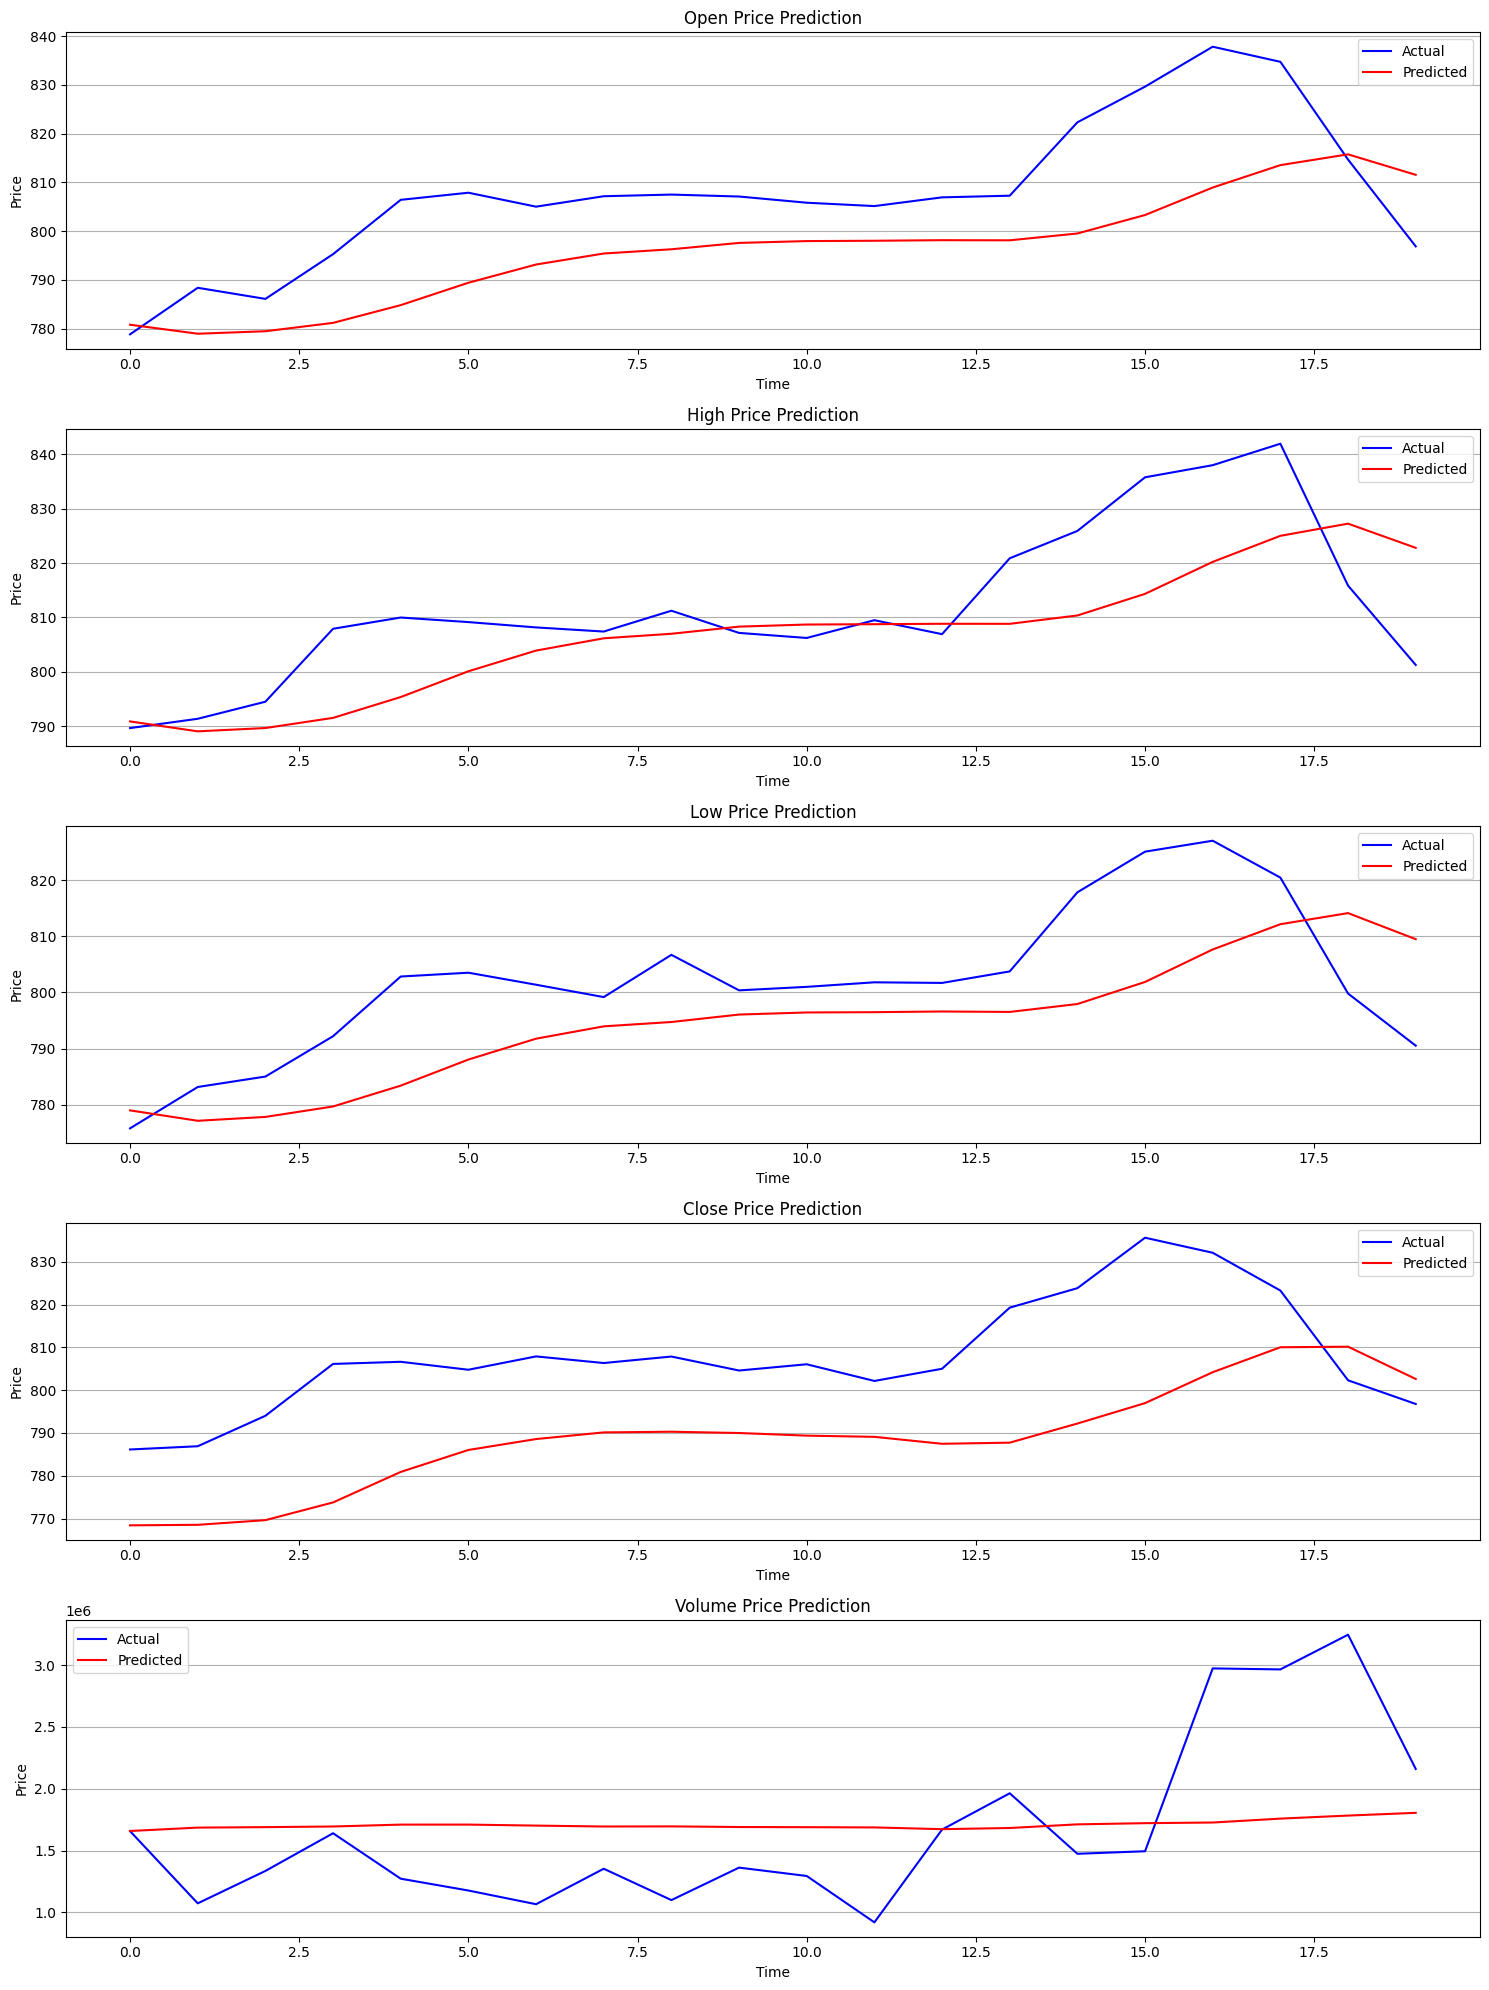

In [58]:

fig, axes = plt.subplots(5, 1, figsize=(15, 20))
features = ['Open', 'High', 'Low', 'Close', 'Volume']

for i, (ax, feature) in enumerate(zip(axes, features)):
    ax.plot(actual_original_test[:, i], label='Actual', color='blue')
    ax.plot(predictions_original_test[:, i], label='Predicted', color='red')
    ax.set_title(f'{feature} Price Prediction')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

In [59]:
# calculate MAE, RMSE and MAPE
mae = np.mean(np.abs(predictions_original_test - actual_original_test), axis=0)
rmse = np.sqrt(np.mean((predictions_original_test - actual_original_test) ** 2, axis=0))
mape = np.mean(np.abs((actual_original_test - predictions_original_test) / actual_original_test), axis=0) * 100

features = ['Open', 'High', 'Low', 'Close', 'Volume']
print("\nModel Performance on Test Set (Original Scale):")

print("\nMean Absolute Error (MAE):")
for feature, mae_value in zip(features, mae):
    print(f"{feature}: {mae_value:.2f}")

print("\nRoot Mean Squared Error (RMSE):")
for feature, rmse_value in zip(features, rmse):
    print(f"{feature}: {rmse_value:.2f}")

print("\nMean Absolute Percentage Error (MAPE):")
for feature, mape_value in zip(features, mape):
    print(f"{feature}: {mape_value:.2f}%")


Model Performance on Test Set (Original Scale):

Mean Absolute Error (MAE):
Open: 13.22
High: 9.06
Low: 11.05
Close: 20.47
Volume: 504098.41

Root Mean Squared Error (RMSE):
Open: 15.21
High: 11.60
Low: 12.69
Close: 22.11
Volume: 639471.94

Mean Absolute Percentage Error (MAPE):
Open: 1.63%
High: 1.11%
Low: 1.37%
Close: 2.52%
Volume: 31.71%


We want to see the performance on the entire timeline.

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


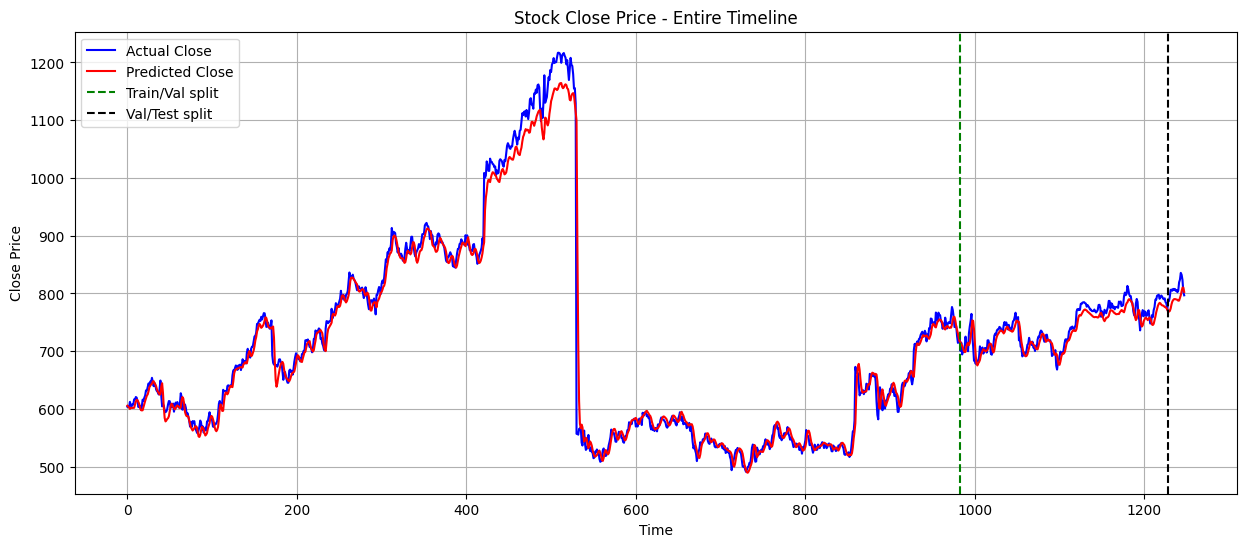

In [60]:
# predict on all data
predictions_all = best_model_tuned.predict(X)  # use all X data
predictions_all_original = scaler.inverse_transform(predictions_all)
actual_all_original = scaler.inverse_transform(y)

# plot the comparison of Close price
plt.figure(figsize=(15, 6))
plt.plot(actual_all_original[:, 3], label='Actual Close', color='blue')
plt.plot(predictions_all_original[:, 3], label='Predicted Close', color='red')

# add vertical lines to mark the split of training, validation and test set
train_size = len(X_train)
val_size = len(X_val)
plt.axvline(x=train_size, color='g', linestyle='--', label='Train/Val split')
plt.axvline(x=train_size+val_size, color='k', linestyle='--', label='Val/Test split')

plt.title('Stock Close Price - Entire Timeline')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()